In [1]:
%load_ext cython
import cbclib as cbc
import numpy as np
import pyximport
from importlib import reload
import sys
import os
import h5py
import matplotlib.animation as animation
from tqdm.auto import tqdm
from cbclib.bin import *
from scipy import ndimage
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport.pyximport.PyxImporter at 0x2b4548ea6f10>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['ArrayWrapper', 'LSD', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'draw_lines', 'maximum_filter', 'median_filter', 'np', 'pair_streaks', 'subtract_background']


In [6]:
scan_num = 209 # whitefield, 2s exposure

loader = cbc.CXILoader()
wf_data = cbc.converter_petra('/asap3/petra3/gpfs/p11/2021/data/11010570/raw', 209, None)
wf_data = wf_data.update_mask(method='range-bad', vmax=10000000)
whitefield = np.mean(wf_data.get('data') * wf_data.get('mask'), axis=0)
mask = np.any(wf_data.mask, axis=0)

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
wf_data.translations, wf_data.tilts

(array([[-0.009231  ,  0.000399  , -0.01052872],
        [-0.009231  ,  0.0004    , -0.01052872],
        [-0.009231  ,  0.000401  , -0.01052872],
        [-0.00923   ,  0.000399  , -0.01052872],
        [-0.00923   ,  0.0004    , -0.01052872],
        [-0.00923   ,  0.000401  , -0.01052872],
        [-0.009229  ,  0.000399  , -0.01052872],
        [-0.009229  ,  0.0004    , -0.01052872],
        [-0.009229  ,  0.000401  , -0.01052872]]),
 array([-3.942308, -3.942308, -3.942308, -3.942308, -3.942308, -3.942308,
        -3.942308, -3.942308, -3.942308]))

In [5]:
log_loader = cbc.LogProtocol()
log_attrs = log_loader.load_attributes(log_path)
log_data = log_loader.load_data(log_path)

In [4]:
scan_num = 213 # B12 protein crystal, 1s exposure, 50 frames
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])
master_file = [os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('master.h5')][0]

center_roi = [2150, 2300, 1900, 2030]
mask[center_roi[0]:center_roi[1], center_roi[2]:center_roi[3]] = False

data = loader.load(h5_files, master_file, mask=mask, roi=(1100, 3260, 1040, 3108), whitefield=whitefield / 2)

Loading data:   0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
log_path

'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_213.log'

In [3]:
scan_num = 250 # Lysozyme crystal, 1s exposure, 101 x 4 x 4 frames
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])
master_file = [os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('master.h5')][0]

cxi_loader = cbc.CXILoader()

In [4]:
idxs = slice(1 * 101, 2 * 101, 2)
paths, cxi_paths, indices = cxi_loader.read_data_indices(h5_files)
wf_data = cxi_loader.load(h5_files, master_file, pupil=(2200, 2370, 1900, 2110),
                      data_indices=(paths[idxs], cxi_paths[idxs], indices[idxs]))
wf_data = wf_data.update_mask(method='range-bad', vmax=10000000)
wf_data = wf_data.update_mask(method='perc-bad', update='multiply')

Loading data:   0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
whitefield = np.mean(wf_data.get('data') * wf_data.get('mask'), axis=0)
mask = np.any(wf_data.mask, axis=0)

In [8]:
idxs = slice(10 * 101, 11 * 101, 1)
paths, cxi_paths, indices = loader.read_data_indices(h5_files)
data = loader.load(h5_files, master_file, mask=mask, whitefield=whitefield,
                   pupil=(2200, 2370, 1900, 2110), roi=(700, 3660, 640, 3508),
                   data_indices=(paths[idxs], cxi_paths[idxs], indices[idxs]))

Loading data:   0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


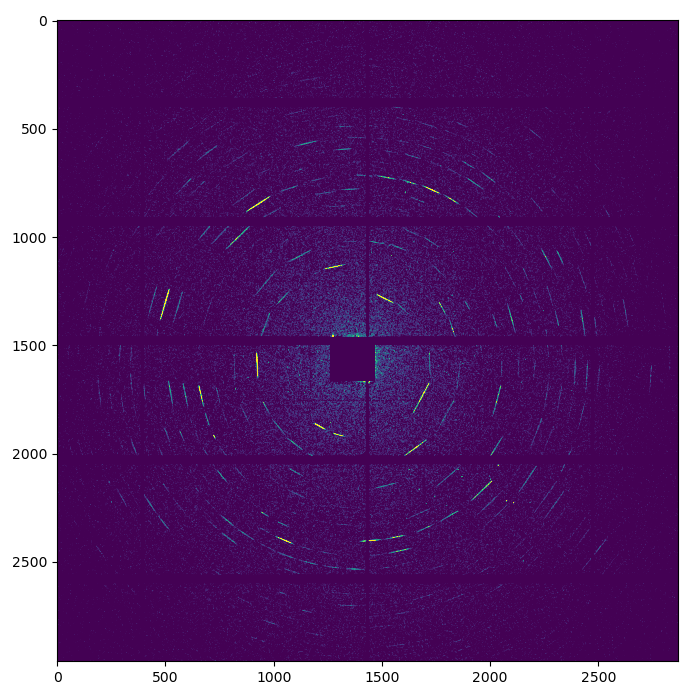

In [9]:
%matplotlib notebook
frame_idx = 33

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.imshow(wf_data.get('data')[frame_idx] * wf_data.get('mask')[frame_idx], vmax=3)
# ax.imshow(data.get('data')[frame_idx] * data.get('mask')[frame_idx], vmax=3)
ax.imshow(data.get('cor_data')[frame_idx], vmin=0.3, vmax=3)
# ax.imshow(det_obj.streak_data[frame_idx], vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [10]:
det_obj = cbc.StreakDetector.import_data(data, 0., 3., (1, 3, 3))
det_obj = det_obj.update_lsd(scale=0.9, sigma_scale=0.9, log_eps=0, ang_th=60, density_th=0.5, quant=2e-2)

In [26]:
%time det_obj = det_obj.update_mask(dilation=8)
%time det_obj = det_obj.update_streak_data(iterations=4)

CPU times: user 2min 19s, sys: 30.9 s, total: 2min 50s
Wall time: 10.9 s
CPU times: user 1min 1s, sys: 29 s, total: 1min 30s
Wall time: 28.1 s


In [20]:
det_obj = det_obj.update_lsd(scale=0.9, sigma_scale=0.9, log_eps=0, ang_th=60, density_th=0.5, quant=1.8e-2)
%time det_new = det_obj.update_mask(dilation=8)
# %time det_new = det_new.update_streak_data(iterations=8)

CPU times: user 1min 57s, sys: 16.3 s, total: 2min 13s
Wall time: 7.96 s


<IPython.core.display.Javascript object>


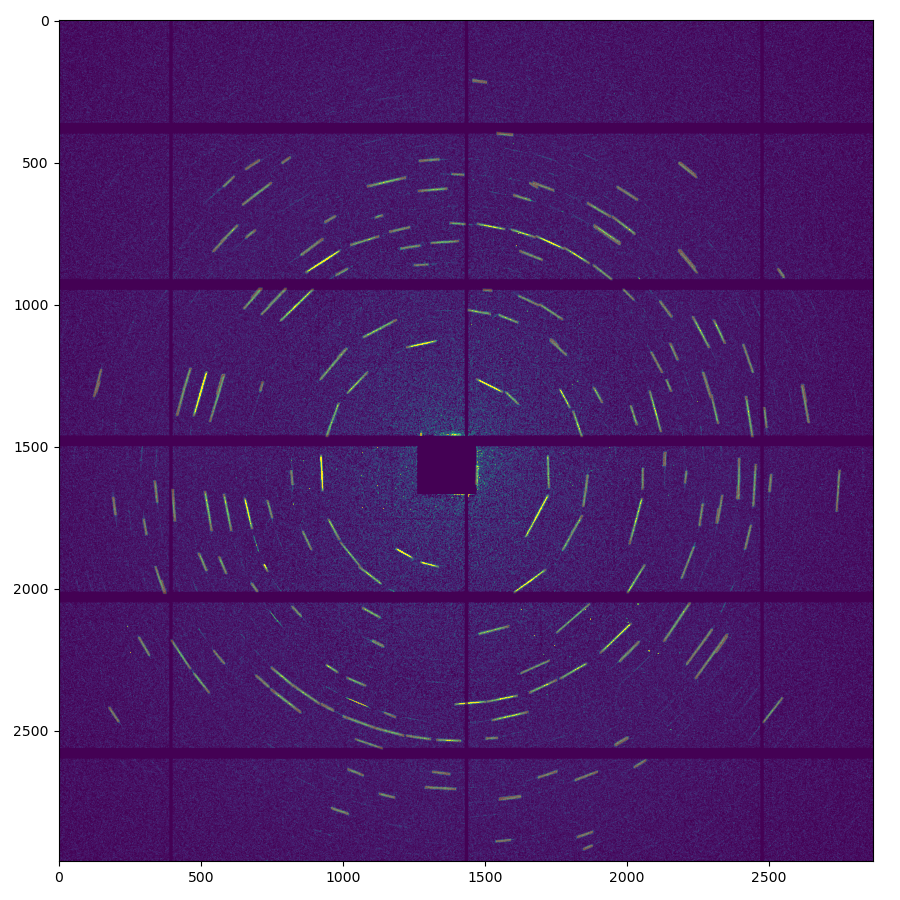

In [31]:
%matplotlib notebook
frame_idx = 33

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.imshow(data.get('cor_data')[frame_idx], vmax=3)
# ax.imshow(det_obj.streak_data[frame_idx], vmax=1)
# ax.scatter(det_obj.center[1], det_obj.center[0], s=100)
ax.imshow(det_obj.streak_mask[frame_idx], vmax=1, alpha=0.3)
plt.tight_layout()
plt.show()

# Experimental geometry

In [9]:
log_prt = cbc.LogProtocol()
foc_z = -12028.122000000001
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
log_path = os.path.join(dir_path, f'server_log/Scan_logs/Scan_{254:d}.log')
log_prt.load_attributes(log_path)['Session logged attributes']['z_sample'] * 1e6 - foc_z

5890.255000000001

In [6]:
scan_num = 253 # Det dist = 40 cm
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])
master_file = [os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('master.h5')][0]
loader = cbc.CXILoader()

data_indices = loader.read_data_indices(h5_files)
frames = loader.load_data(data_indices).sum(axis=0, keepdims=True)
attr_dict = {attr: val for attr, val in loader.load_attributes(master_file).items()
             if not val is None}

data = cbc.CrystData(protocol=loader.get_protocol(), data=frames, mask=mask,
                     pupil=(2200, 2370, 1900, 2110), roi=(1100, 3260, 1040, 3108),
                     whitefield=3.0 * whitefield, **attr_dict)

Loading data:   0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
det_obj = cbc.StreakDetector.import_data(data, 0.2, 3., (1, 3, 3))
det_obj = det_obj.update_lsd(scale=0.9, sigma_scale=0.9, log_eps=0, ang_th=60, density_th=0.5, quant=1.5e-2)
det_obj = det_obj.update_mask(dilation=8)
det_obj = det_obj.update_streak_data(iterations=4)

In [34]:
scan_num = 254 # Det dist = 55 cm
h5_dir = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/scan_frames/Scan_{scan_num:d}'
log_path = f'/asap3/petra3/gpfs/p11/2021/data/11010570/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('.h5') and not path.endswith('master.h5')])
master_file = [os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                if path.endswith('master.h5')][0]

data_indices = loader.read_data_indices(h5_files)
frames = loader.load_data(data_indices).sum(axis=0, keepdims=True)
attr_dict = {attr: val for attr, val in loader.load_attributes(master_file).items()
             if not val is None}
whitefield_2 = np.zeros(frames.shape[1:], dtype=np.float64)
whitefield_2[29:, 41:] = whitefield[:-29, :-41]
mask_2 = np.ones(frames.shape[1:], dtype=bool)
mask_2[29:, 41:] = mask[:-29, :-41]

data_2 = cbc.CrystData(protocol=loader.get_protocol(), data=frames, mask=mask * mask_2,
                       pupil=(2140, 2450, 1900, 2200), roi=(700, 3660, 640, 3508),
                       whitefield=3.0 * whitefield_2, **attr_dict)

Loading data:   0%|          | 0/3 [00:00<?, ?it/s]

In [109]:
pupil = np.array([2214, 2400, 1974, 2155])
db = np.array([2159, 1913])

center = db + np.mean(((pupil - np.repeat(db, 2)) * 5.89e-3 / 0.55).reshape((2, 2)), axis=1)
center

array([2160.58494545, 1914.62242727])

In [41]:
det_obj_2 = cbc.StreakDetector.import_data(data_2, 0.2, 2., (1, 3, 3))
det_obj_2 = det_obj_2.update_lsd(scale=0.9, sigma_scale=0.9, log_eps=0, ang_th=60, density_th=0.5, quant=1.8e-2)
det_obj_2 = det_obj_2.update_mask(dilation=8)
det_obj_2 = det_obj_2.update_streak_data(iterations=4)

<IPython.core.display.Javascript object>


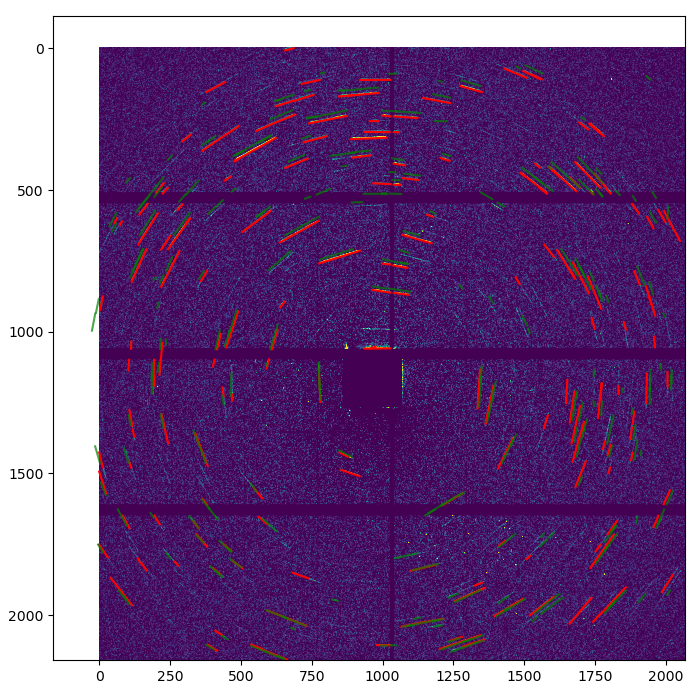

In [125]:
%matplotlib notebook
frame_idx = 0
scale = 0.73

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(data.get('cor_data')[frame_idx], vmin=0.2, vmax=3.)
for line in det_obj.streaks[frame_idx]:
    ax.plot(line[:4:2], line[1:4:2], line[4], c='r')
for line in det_obj_2.streaks[frame_idx]:
    ax.plot((line[:4:2] + data_2.roi[2] - center[1]) * scale + center[1] - data.roi[2],
            (line[1:4:2] + data_2.roi[0] - center[0]) * scale + center[0] - data.roi[0],
            line[4], c='g', alpha=0.7)
# ax.imshow(data.get('data')[frame_idx] * data.get('mask')[frame_idx], vmax=3)
# ax.imshow(det_obj.streak_data[frame_idx], vmin=0, vmax=1)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


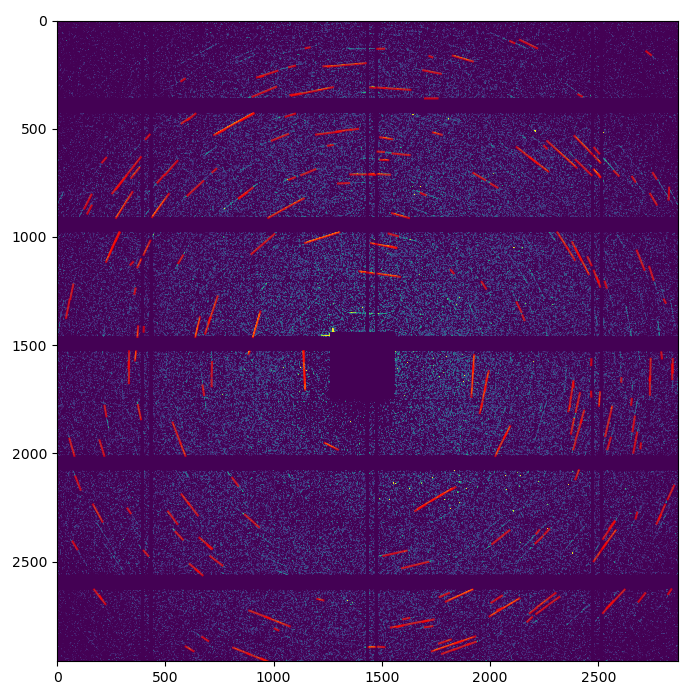

In [42]:
%matplotlib notebook
frame_idx = 0

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
# ax.imshow(det_obj_2.streak_data[frame_idx], vmax=1)
# ax.imshow(data.get('data')[frame_idx] * data.get('mask')[frame_idx], vmax=3)
ax.imshow(data_2.get('cor_data')[frame_idx], vmin=0.4, vmax=2.)
for line in det_obj_2.streaks[frame_idx]:
    ax.plot(line[:4:2], line[1:4:2], line[4], c='r', alpha=0.7)
ax.set_xlim(0, data_2.roi[3] - data_2.roi[2])
ax.set_ylim(data_2.roi[1] - data_2.roi[0], 0)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


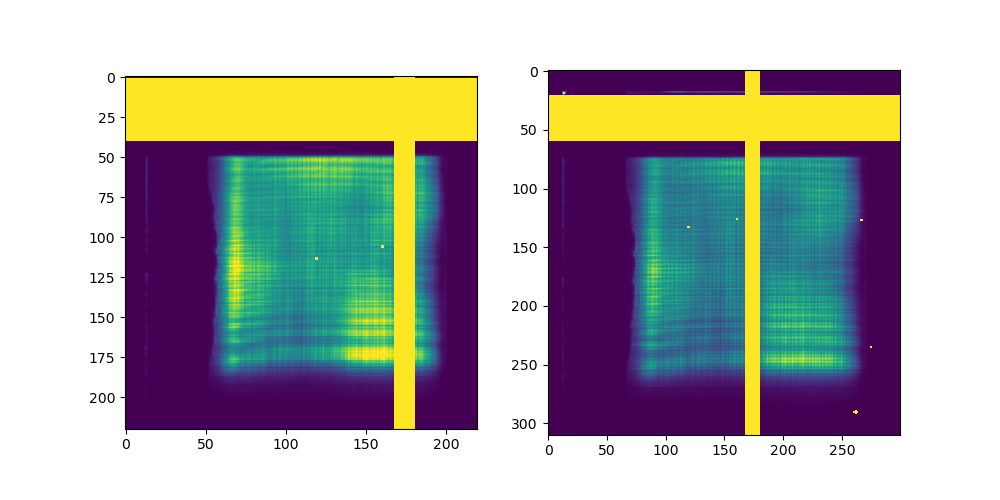

In [103]:
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data.data[0, 2160:2380, 1900:2120], vmax=300000)
ax[1].imshow(data_2.data[0, 2140:2450, 1900:2200], vmax=200000)
plt.show()

<IPython.core.display.Javascript object>


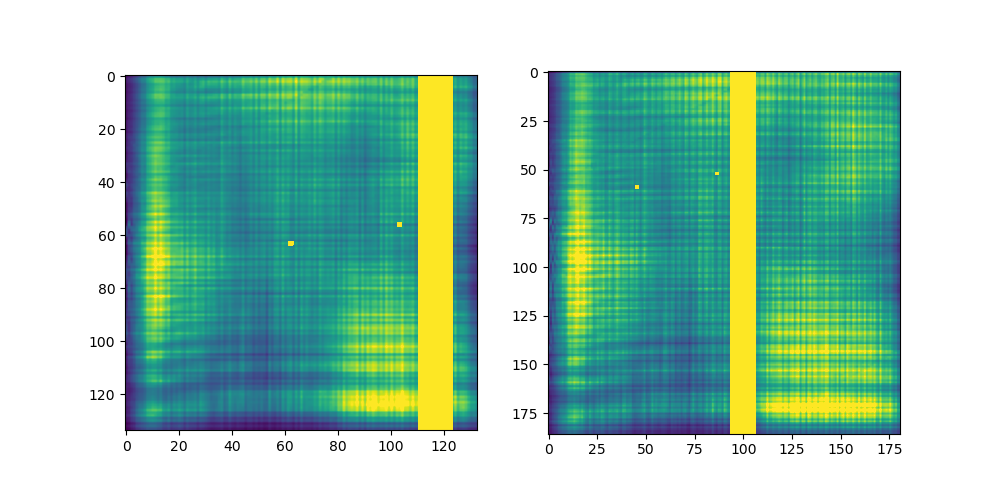

In [122]:
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data.data[0, 2210:2344, 1957:2090], vmax=300000)
ax[1].imshow(data_2.data[0, 2214:2400, 1974:2155], vmax=150000)
plt.show()